# Method for visualizing warping over training steps

In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

### Construct warping matrix

In [3]:
g = 1.02 # scaling parameter

# Matrix for rotating 45 degrees
rotate = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                   [np.sin(np.pi/4), np.cos(np.pi/4)]])

# Matrix for scaling along x coordinate
scale_x = np.array([[g, 0],
                    [0, 1]])

# Matrix for scaling along y coordinate
scale_y = np.array([[1, 0],
                    [0, g]])

# Matrix for unrotating (-45 degrees)
unrotate = np.array([[np.cos(-np.pi/4), -np.sin(-np.pi/4)],
                     [np.sin(-np.pi/4), np.cos(-np.pi/4)]])

# Warping matrix
warp = rotate @ scale_x @ unrotate

# Unwarping matrix
unwarp = rotate @ scale_y @ unrotate

### Warp grid slowly over time

In [4]:
# Construct 4x4 grid
s = 1 # initial scale
locs = [[x,y] for x in range(4) for y in range(4)]
grid = s*np.array(locs)

In [5]:
# Matrix to collect data
n_steps = 50
warp_data = np.zeros([n_steps, 16, 2])

# Initial timestep has no warping
warp_data[0,:,:] = grid

# Warp slowly over time
for i in range(1,n_steps):
    grid = grid @ warp
    warp_data[i,:,:] = grid
    

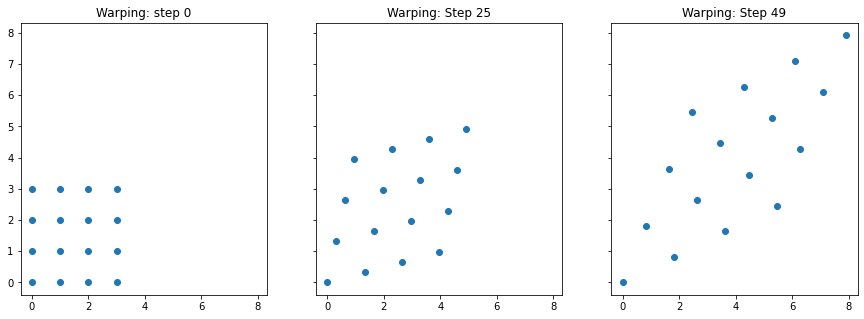

In [6]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].scatter(warp_data[0,:,0], warp_data[0,:,1])
ax[0].set_title("Warping: step 0")
ax[1].scatter(warp_data[n_steps//2,:,0], warp_data[n_steps//2,:,1])
ax[1].set_title("Warping: Step {}".format(n_steps//2))
ax[2].scatter(warp_data[n_steps-1,:,0], warp_data[n_steps-1,:,1])
ax[2].set_title("Warping: Step {}".format(n_steps-1))
plt.show()

### Unwarp grid slowly over time

In [7]:
# Matrix to collect data
unwarp_data = np.zeros([n_steps, 16, 2])

# Start with warped grid
unwarp_data[0,:,:] = grid

# Unwarp slowly over time
for i in range(1,n_steps):
    grid = grid @ unwarp
    unwarp_data[i,:,:] = grid

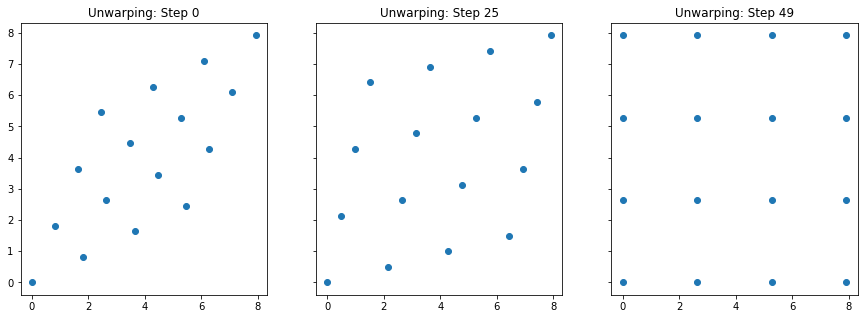

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharex=True, sharey=True)
ax[0].scatter(unwarp_data[0,:,0], unwarp_data[0,:,1])
ax[0].set_title("Unwarping: Step 0")
# ax[0].set_ylim([-0.02, 0.05])
# ax[0].set_xlim([-0.02, 0.05])
ax[1].scatter(unwarp_data[n_steps//2,:,0], unwarp_data[n_steps//2,:,1])
ax[1].set_title("Unwarping: Step {}".format(n_steps//2))
ax[2].scatter(unwarp_data[n_steps-1,:,0], unwarp_data[n_steps-1,:,1])
ax[2].set_title("Unwarping: Step {}".format(n_steps-1))
plt.show()

### High-dimensional vectors with random projection matrix

In [9]:
# data = [warp_data, unwarp_data]
data = np.concatenate([warp_data, unwarp_data], axis=0)

# Random projection matrix
hidden_dim = 32
random_mat = np.random.randn(2, hidden_dim)
data = data @ random_mat

# Add noise to each time step
sigma = 0.2
noise = sigma*np.random.randn(2*n_steps, 16, hidden_dim)
data = data + noise


### Parameterize scatterplot with average "congruent" and "incongruent" distances

In [10]:
loc2idx = {i:(loc[0],loc[1]) for i,loc in enumerate(locs)}
idx2loc = {v:k for k,v in loc2idx.items()}

Function for computing distance matrix

In [11]:
def get_distances(M):
    n,m = M.shape
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = np.linalg.norm(M[i,:] - M[j,:])
    return D

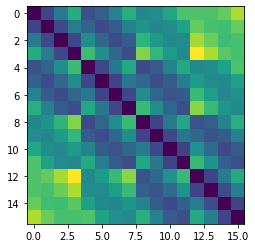

In [12]:
D = get_distances(data[0])
plt.imshow(D)
plt.show()

Construct same-rank groups for "congruent" and "incongruent" diagonals

In [13]:
c_rank = np.array([loc[0] + loc[1] for loc in locs]) # rank along "congruent" diagonal
i_rank = np.array([3 + loc[0] - loc[1] for loc in locs]) # rank along "incongruent" diagonal

G_idxs = [] # same-rank group for "congruent" diagonal
H_idxs = [] # same-rank group for "incongruent" diagonal
for i in range(7): # total number of ranks (0 through 6)
    G_set = [j for j in range(len(c_rank)) if c_rank[j] == i]
    H_set = [j for j in range(len(i_rank)) if i_rank[j] == i]
    G_idxs.append(G_set)
    H_idxs.append(H_set)

Function for estimating $ \alpha $ and $ \beta $

$$ \bar{x_i} = \sum_{x \in G_i} \frac{1}{n} x $$

$$ \alpha_{i, i+1} = || \bar{x}_i - \bar{x}_{i+1} || $$

$$ \bar{y_i} = \sum_{y \in H_i} \frac{1}{n} y $$

$$ \beta_{i, i+1} = || \bar{y}_i - \bar{y}_{i+1} || $$


In [14]:
def get_parameters(M):
    # M: [16, hidden_dim]
    alpha = []
    beta = []
    for i in range(6): # total number of parameters (01,12,23,34,45,56)
        # alpha_{i, i+1}
        x_bar_i = np.mean(M[G_idxs[i],:], axis=0)
        x_bar_ip1 = np.mean(M[G_idxs[i+1],:], axis=0)
        x_dist = np.linalg.norm(x_bar_i - x_bar_ip1)
        alpha.append(x_dist)
        
        # beta_{i, i+1}
        y_bar_i = np.mean(M[H_idxs[i],:], axis=0)
        y_bar_ip1 = np.mean(M[H_idxs[i+1],:], axis=0)
        y_dist = np.linalg.norm(y_bar_i - y_bar_ip1)
        beta.append(y_dist)
        
    return alpha, beta

In [15]:
alpha_data = []
beta_data = []
for t in range(len(data)):
    alpha, beta = get_parameters(data[t])
    alpha_data.append(alpha)
    beta_data.append(beta)

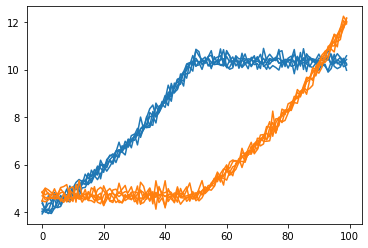

In [16]:
plt.plot(alpha_data, color='tab:blue')
plt.plot(beta_data, color='tab:orange')
plt.show()

Use parameters to plot idealized 2D representations

In [17]:
idx2g = {}
for idx in range(16):
    for g, group in enumerate(G_idxs):
        if idx in group:
            idx2g[idx] = g

idx2h = {}
for idx in range(16):
    for h, group in enumerate(H_idxs):
        if idx in group:
            idx2h[idx] = h

In [18]:
def generate_grid(alpha, beta):
    cum_alpha = np.zeros(7)
    cum_beta = np.zeros(7)
    cum_alpha[1:] = np.cumsum(alpha)
    cum_beta[1:] = np.cumsum(beta)
    
    # Get x and y coordinate in rotated basis
    X = np.zeros([16, 2])
    for idx in range(16):
        g = idx2g[idx] # G group
        h = idx2h[idx] # H group
        X[idx,0] = cum_alpha[g] # x coordinate
        X[idx,1] = cum_beta[h]  # y coordinate
    
    # Unrotate
    unrotate = np.array([[np.cos(-np.pi/4), -np.sin(-np.pi/4)],
                        [np.sin(-np.pi/4), np.cos(-np.pi/4)]])
    X = X @ unrotate
    
    # Mean-center
    X = X - np.mean(X, axis=0, keepdims=True)
    
    return X

In [19]:
X = generate_grid(alpha, beta)

Get reconstructed grid for each time step

In [20]:
reconstruction = np.zeros([data.shape[0], data.shape[1], 2])
for t,M in enumerate(data):
    alpha, beta = get_parameters(M)
    X = generate_grid(alpha, beta)
    reconstruction[t,:,:] = X

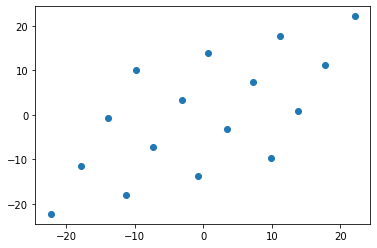

In [21]:
t = 50
plt.scatter(reconstruction[t,:,0], reconstruction[t,:,1])
plt.show()

### Make .gif

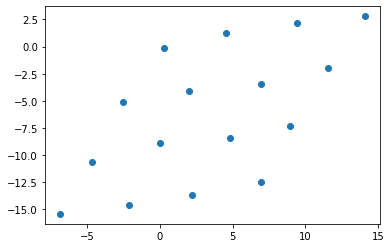

In [22]:
plt.scatter(M[:,0], M[:,1])

In [23]:
reconstruction.shape

(100, 16, 2)

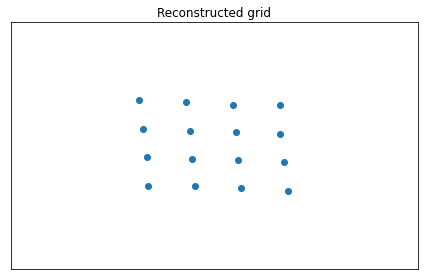

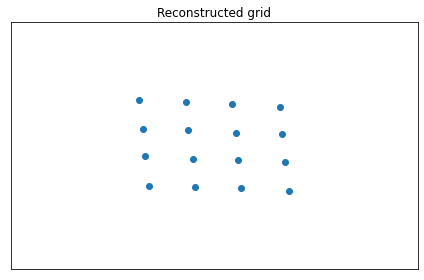

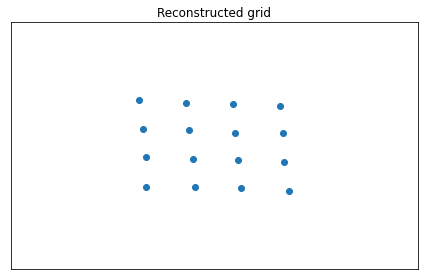

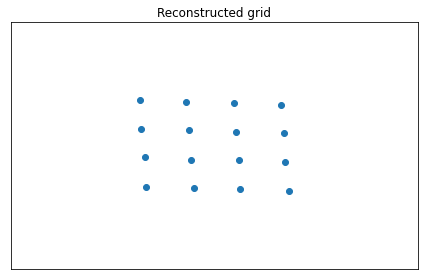

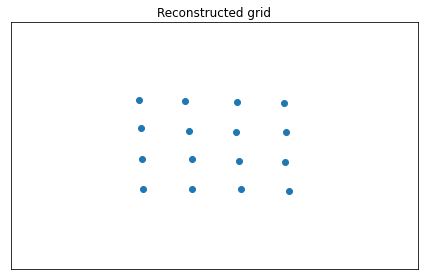

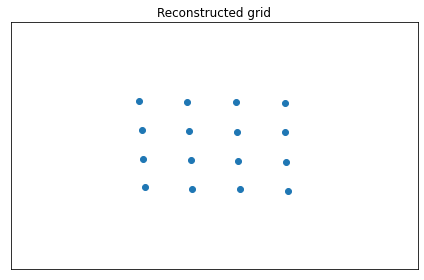

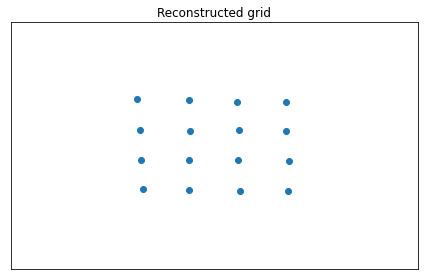

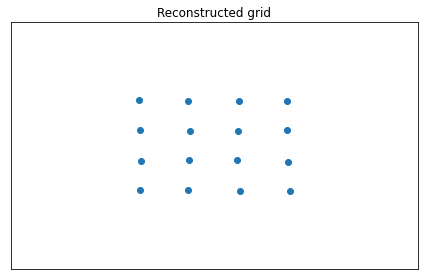

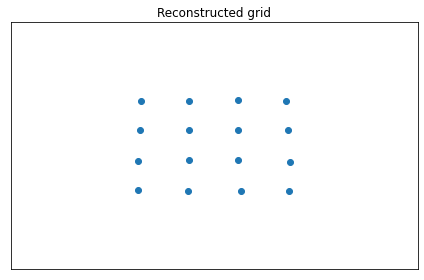

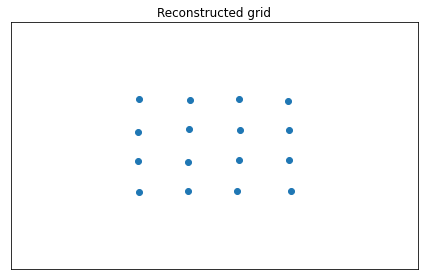

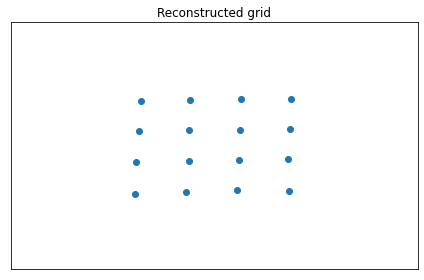

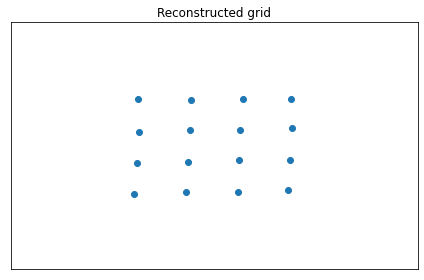

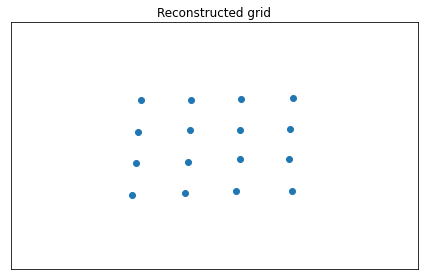

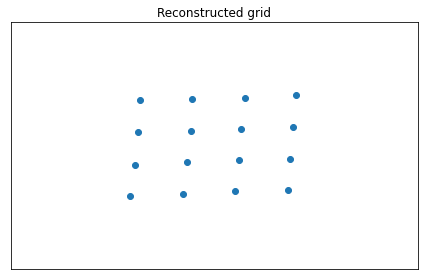

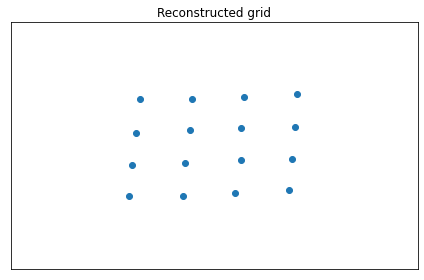

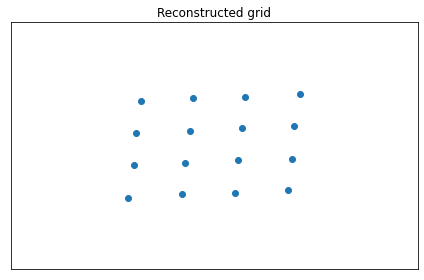

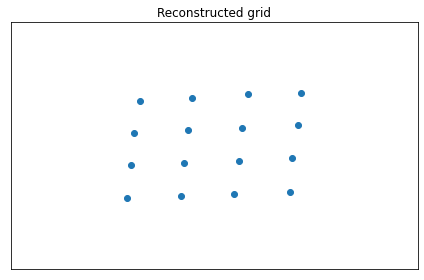

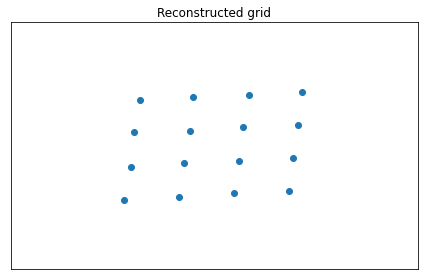

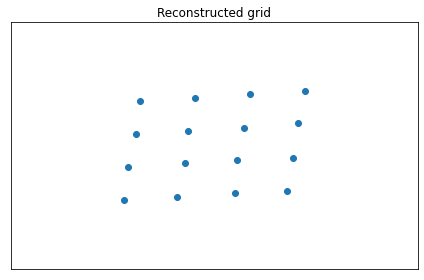

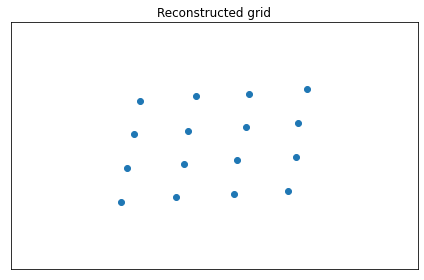

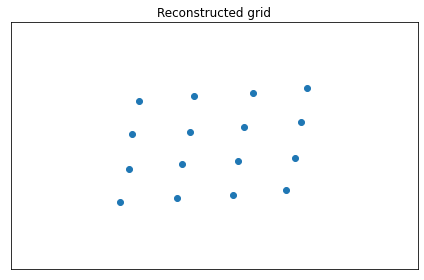

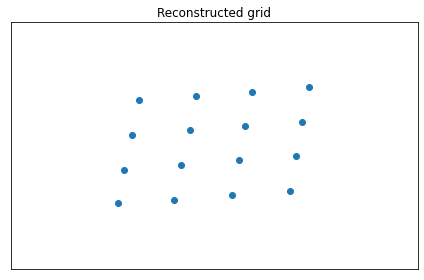

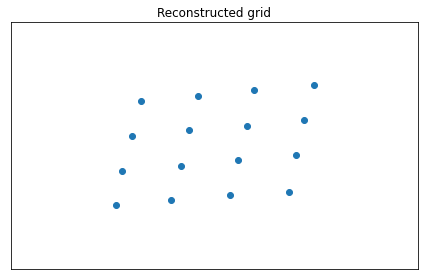

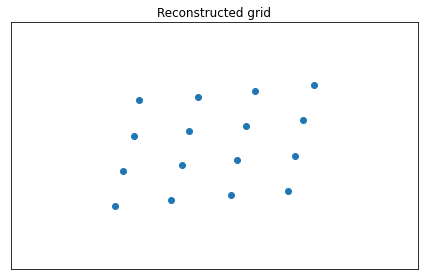

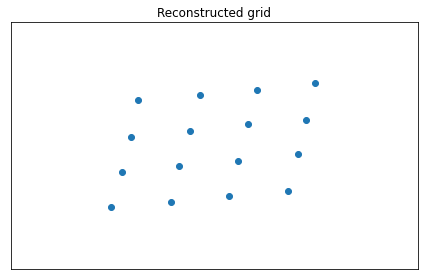

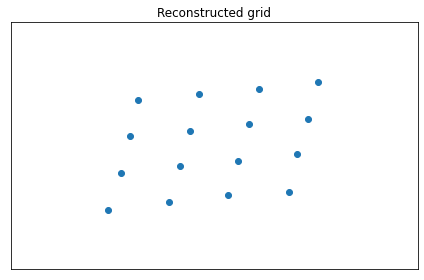

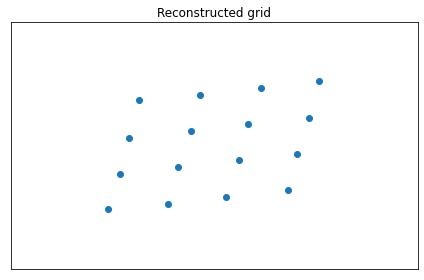

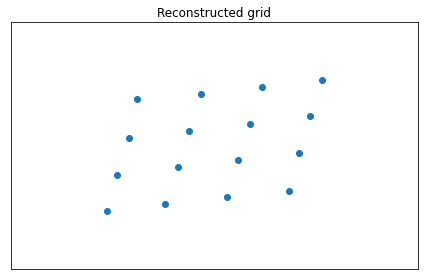

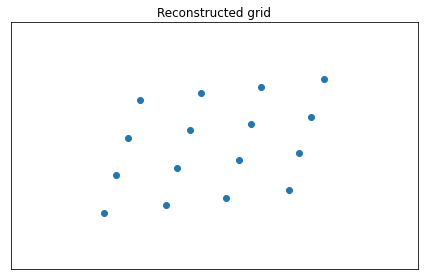

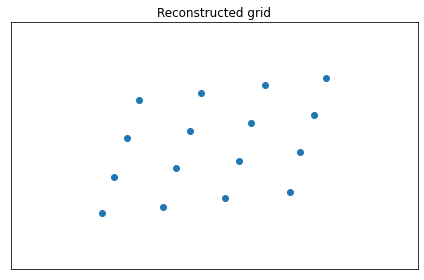

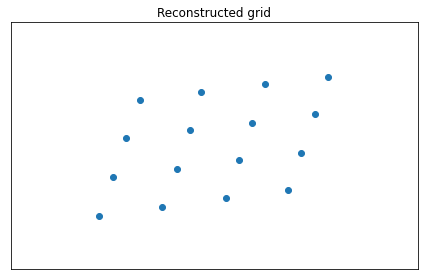

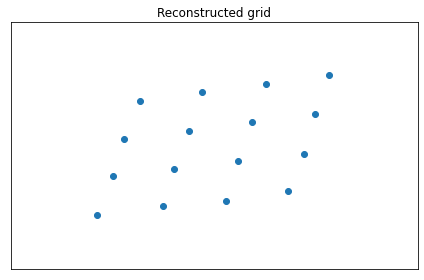

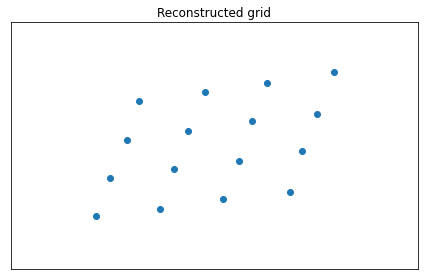

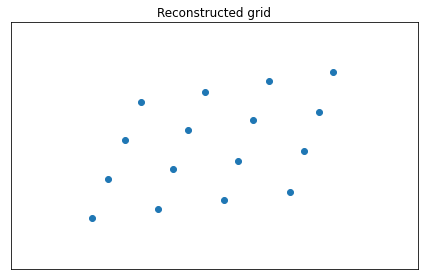

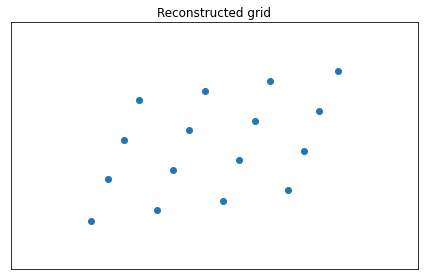

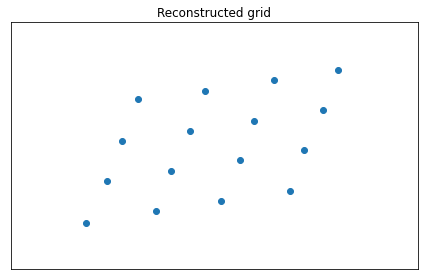

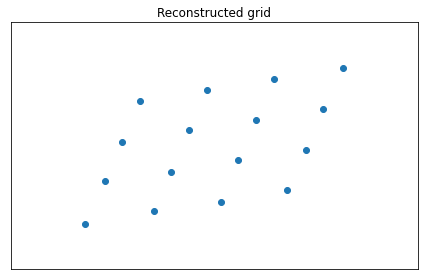

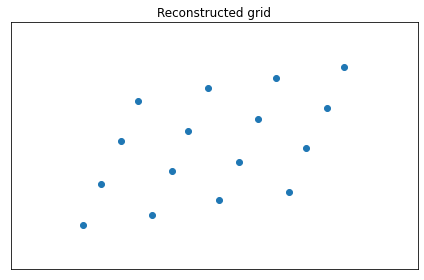

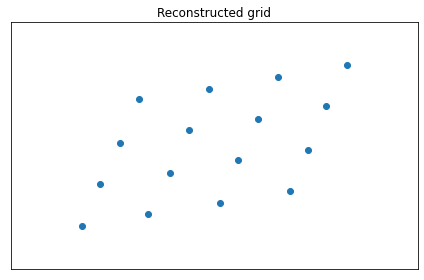

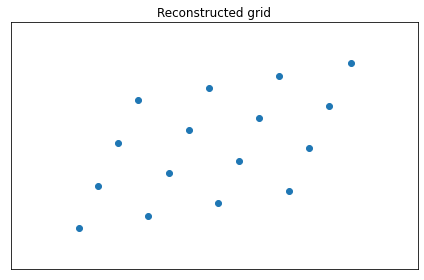

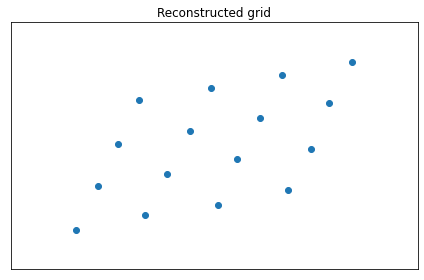

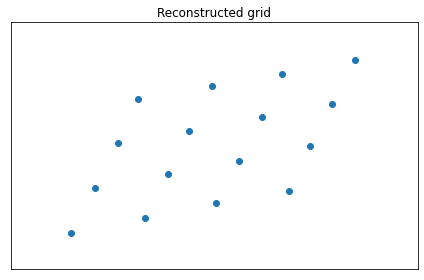

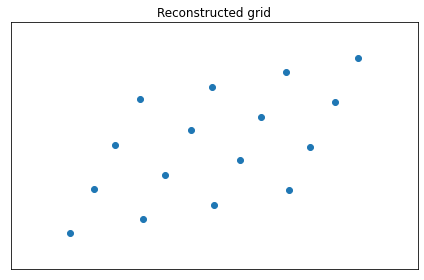

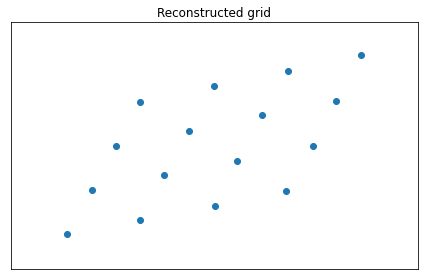

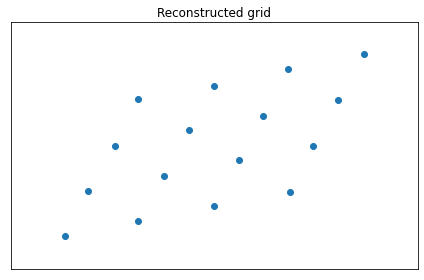

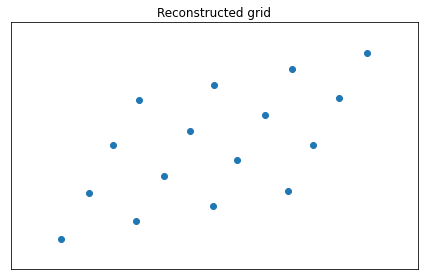

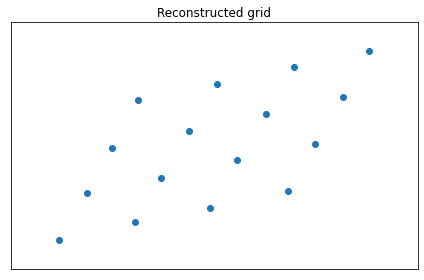

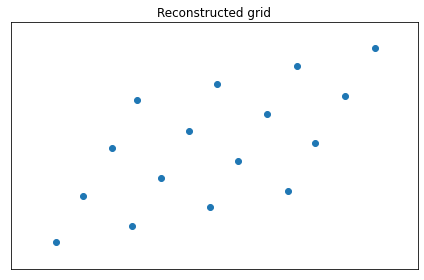

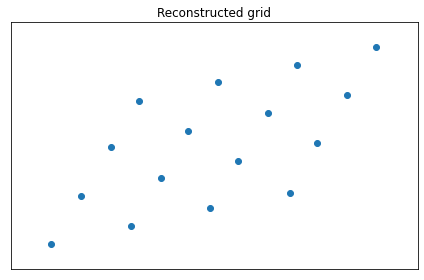

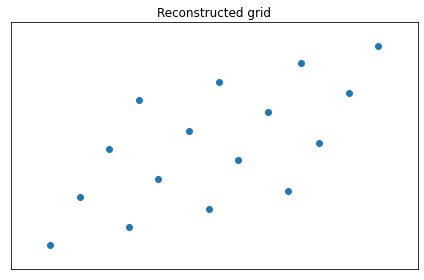

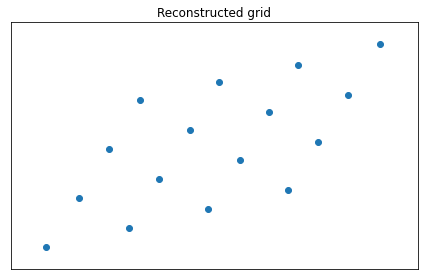

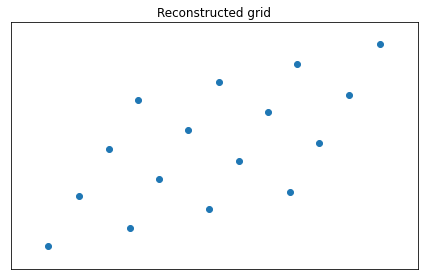

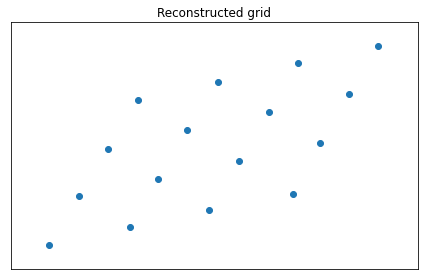

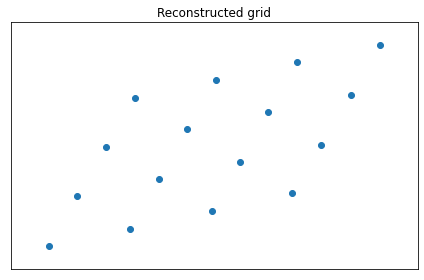

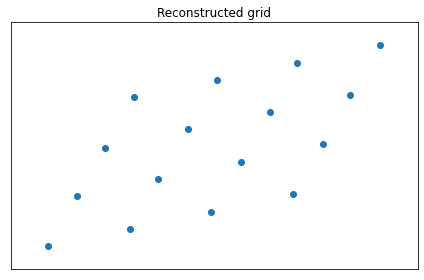

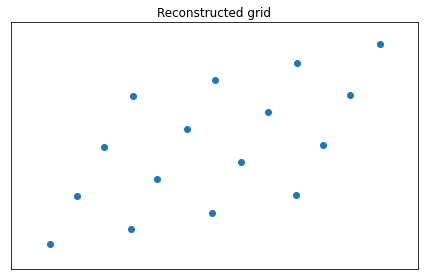

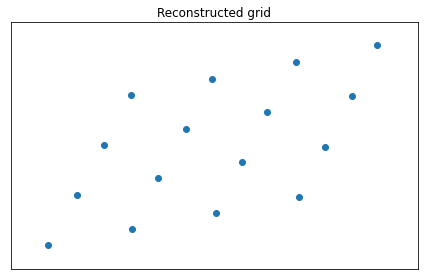

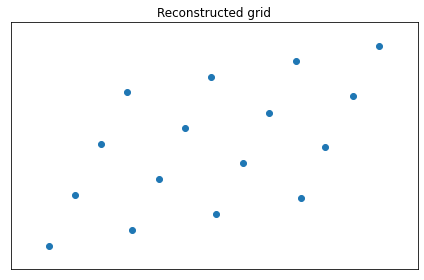

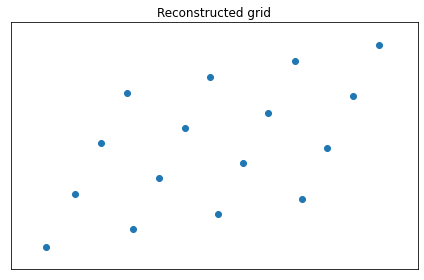

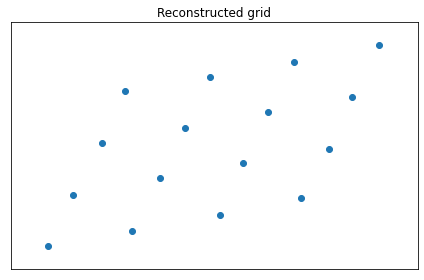

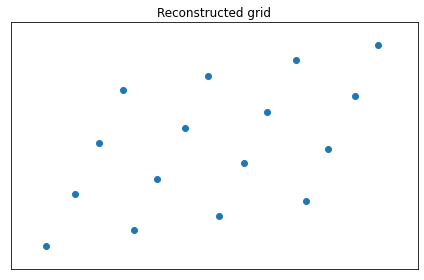

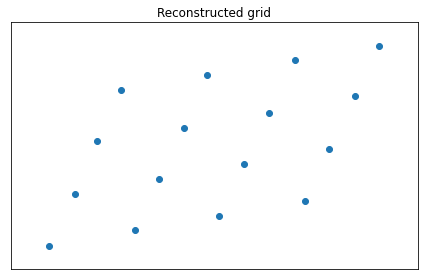

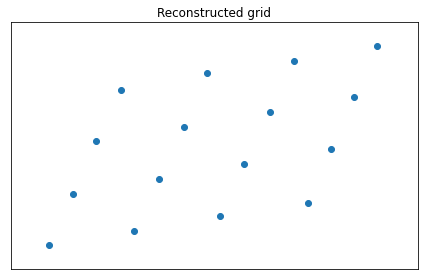

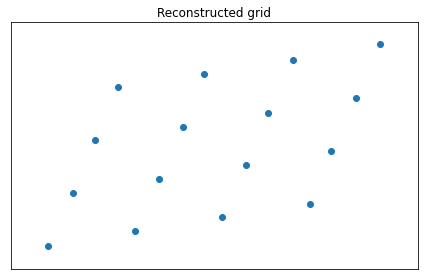

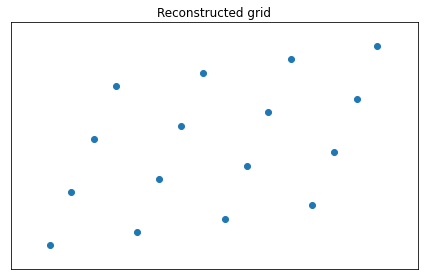

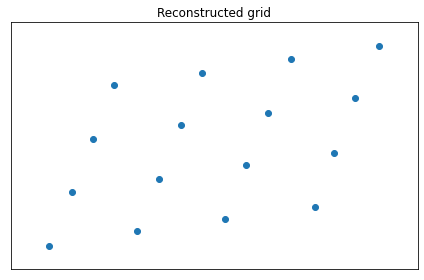

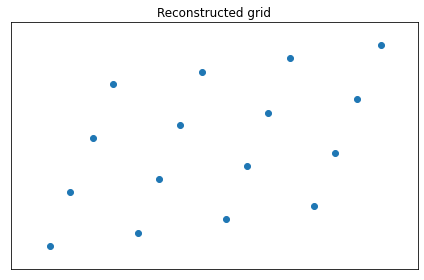

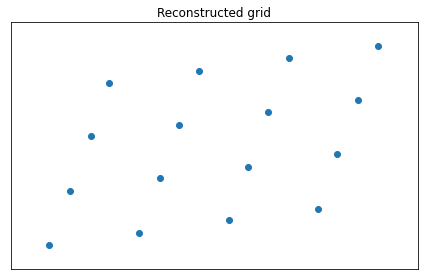

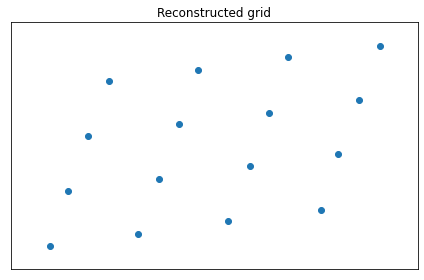

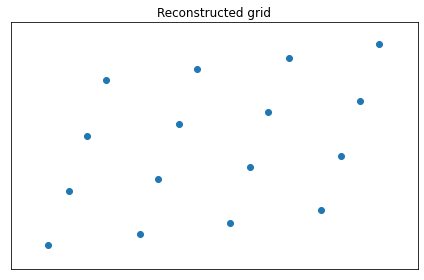

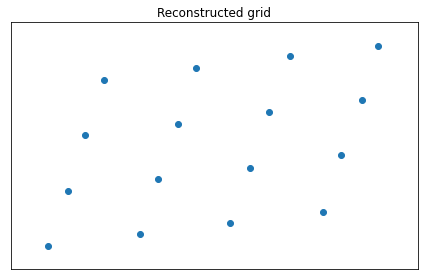

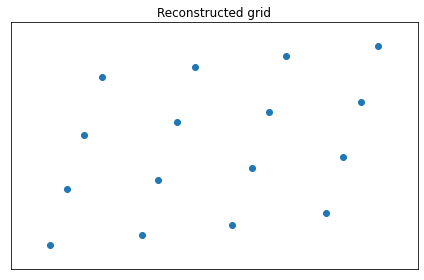

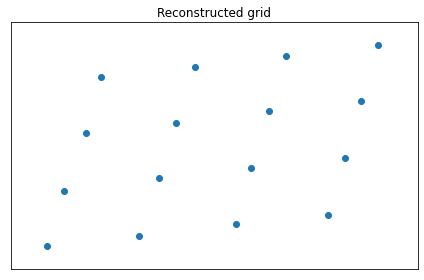

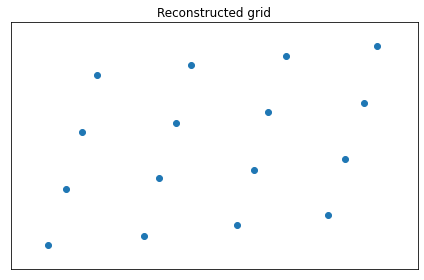

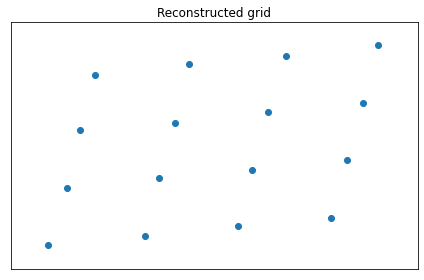

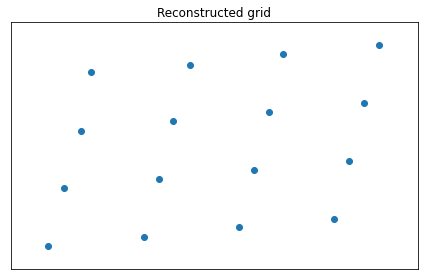

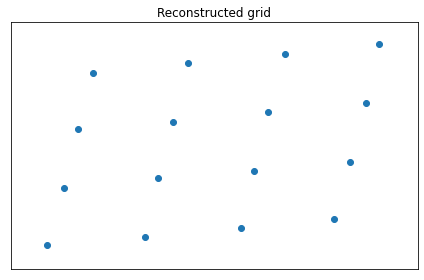

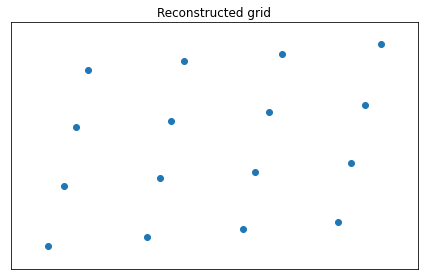

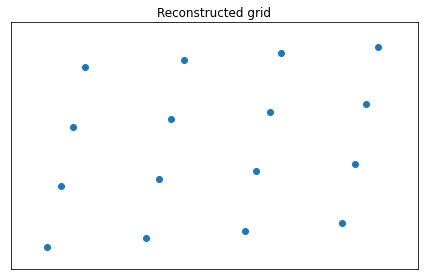

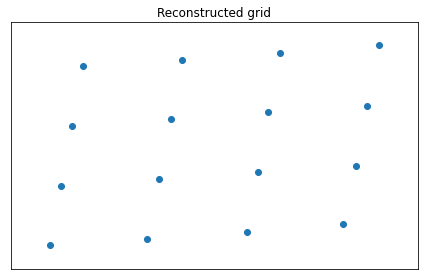

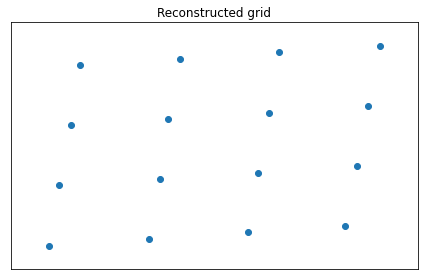

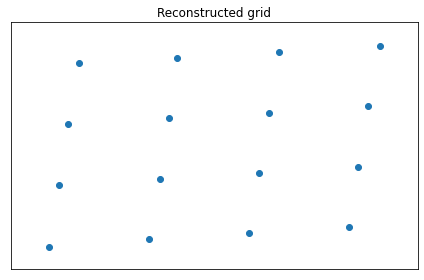

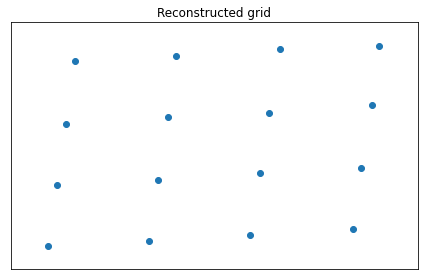

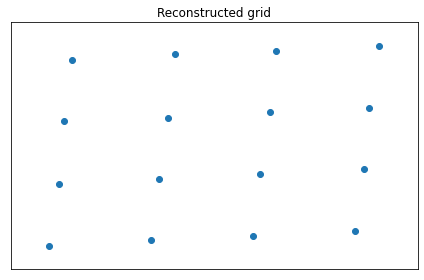

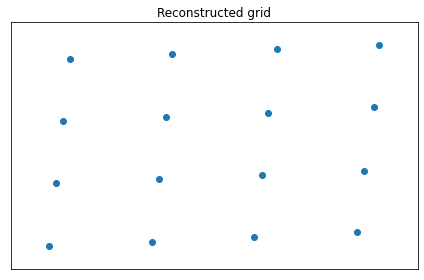

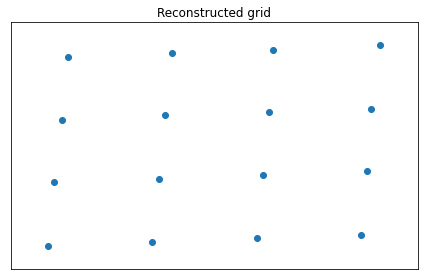

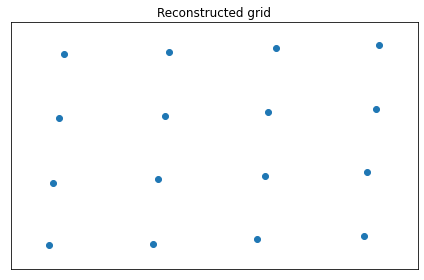

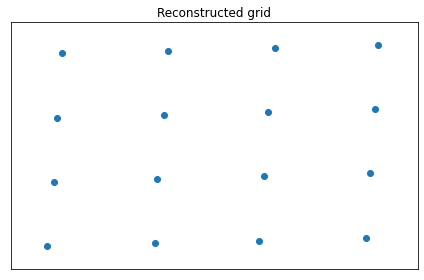

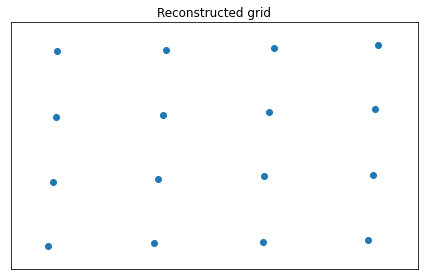

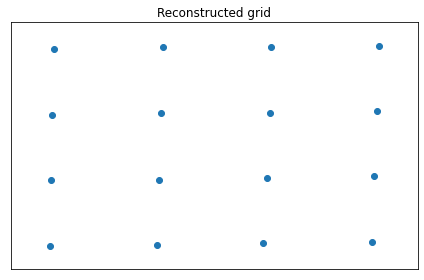

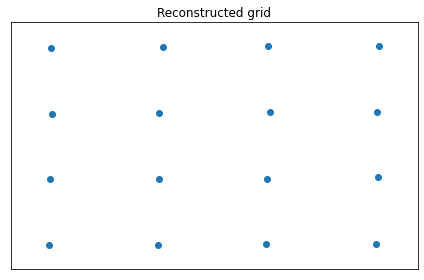

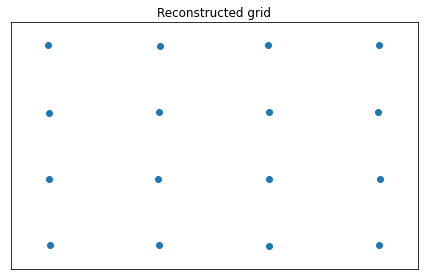

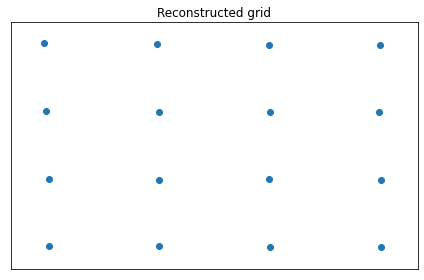

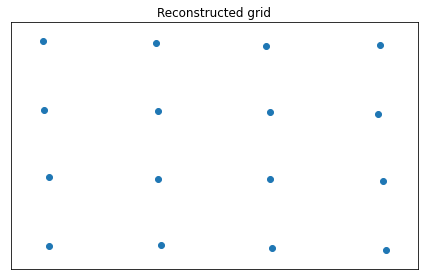

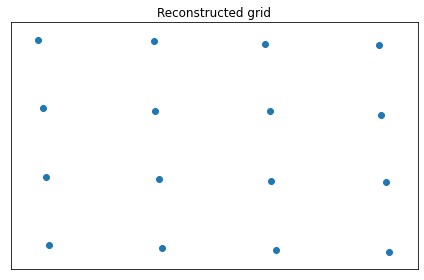

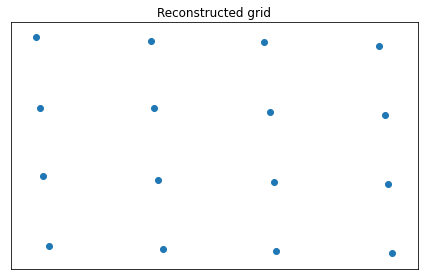

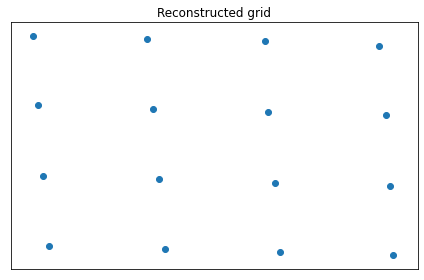

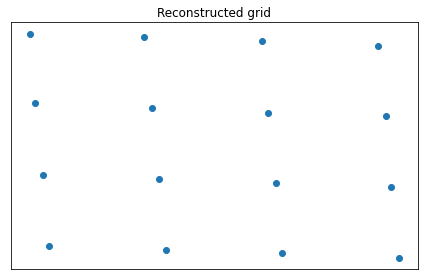

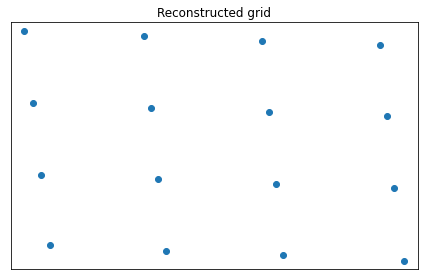

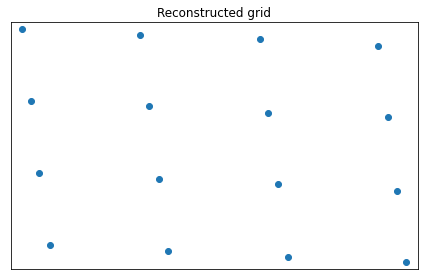

In [24]:
xmin = np.min(reconstruction[:,:,0])
xmax = np.max(reconstruction[:,:,0])
ymin = np.min(reconstruction[:,:,1])
ymax = np.max(reconstruction[:,:,1])
for t,M in enumerate(reconstruction):
    plt.scatter(M[:,0], M[:,1])
    plt.title("Reconstructed grid")
    plt.xlim([xmin-1.5, xmax+1.5])
    plt.ylim([ymin-1.5, ymax+1.5])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig('reconstruction_test_{}.png'.format(t), dpi=100)
    plt.show()

In [25]:
filenames = ['reconstruction_test_{}.png'.format(i) for i in range(2*n_steps)]

In [26]:
with imageio.get_writer('reconstruction_test.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# remove files
for filename in filenames:
    os.remove(filename)

<img src="reconstruction_test.gif" width="750" align="center">